In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pyproj
import dask as dk
import verde as vd
from verde.base import check_fit_input

In [26]:
# Fetch the GPS data from the U.S. West coast. 
data = vd.datasets.fetch_california_gps()
region = vd.get_region((data.longitude, data.latitude))
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

spacing = 20/60

In [3]:
for train, test in KFold(3).split(np.arange(10)):
    print(train, test)

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [4]:
def cross_val_score(estimator, coordinates, data, weights=None, projection=None, cv=None, client=None):
    if client is None:
        client = DummyClient()
    coordinates, data, weights = check_fit_input(coordinates, data, weights, ravel=False)
    if cv is None:
        cv = KFold()
    if projection is not None:
        coordinates = projection(*coordinates)
    ndata = data[0].size
    scores = []
    for train, test in cv.split(np.arange(ndata)):
        score = client.submit(fit_score, estimator, train, test, coordinates, data, weights)
        scores.append(score)
    return scores

def fit_score(estimator, train, test, coordinates, data, weights):    
    train_data, test_data = split_data(train, test, coordinates, data, weights)
    estimator.fit(*train_data)
    return estimator.score(*test_data)     

def split_data(train, test, coordinates, data, weights):
    split = tuple((separate(i, index) for i in (coordinates, data, weights))
                  for index in [train, test])
    return split
            
def separate(data, index):
    if any(i is None for i in data):
        return data
    return tuple(i[index] for i in data)    

In [5]:
def pad_region(region, pad):
    if np.isscalar(pad):
        pad = (pad, pad)
    w, e, s, n = region
    padded = (w - pad[1], e + pad[1], s - pad[0], n + pad[0])
    return padded

def project_region(region, projection):
    w, e, s, n = region
    w, s = projection(w, s)
    e, n = projection(e, n)
    return (w, e, s, n)

In [6]:
force_region = project_region(pad_region(region, pad=1), projection)
force_spacings = [spacing*111e3*scale for scale in [2.5, 3, 3.5]]
force_spacings.append(None)
dampings = [10**i for i in range(-8, -3)]
poissons = [-1, 0.5, 1]
print(force_spacings, dampings)

[138750.0, 166500.0, 194250.0, None] [1e-08, 1e-07, 1e-06, 1e-05, 0.0001]


In [7]:
from dask.distributed import Client, LocalCluster
from dask.distributed import Future

In [8]:
client = Client()

In [10]:
#client.close()

In [9]:
class DummyClient():
    def submit(self, function, *args, **kwargs):
        return function(*args, **kwargs)

In [19]:
#client = DummyClient()

In [11]:
%%time
scores = []
estimators = []
for poisson in poissons:
    for fspacing in force_spacings:
        for damping in dampings:
            chain = vd.Chain([
                ('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
                ('trend', vd.VectorTrend(degree=1)),
                ('spline', vd.Vector2D(poisson=poisson, spacing=fspacing, damping=damping,
                                       force_region=force_region))])
            score = cross_val_score(chain, 
                                    (data.longitude.values, data.latitude.values),
                                    (data.velocity_east, data.velocity_north),
                                    (1/data.std_east**2, 1/data.std_north**2),
                                    projection=projection,
                                    cv=KFold(3, shuffle=True, random_state=0),
                                    client=client)
            scores.append(client.submit(np.mean, score))
            estimators.append(chain)
best = client.submit(np.argmax, scores)
if isinstance(best, Future):
    best = best.result()
    best_score = client.submit(np.max, scores).result()
else:
    best_score = np.max(scores)
chain = estimators[best]

CPU times: user 3.72 s, sys: 345 ms, total: 4.07 s
Wall time: 19.8 s


In [12]:
print("Best score:", best_score)
print("Best estimator:")
print(chain)

Best score: 0.960205831689018
Best estimator:
Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=55500.0, uncertainty=True)), ('trend', VectorTrend(degree=1)), ('spline', Vector2D(damping=0.0001,
     force_region=(-11291905.77172092, -10275765.283748921, 2953120.832779573, 4264463.4295444945),
     fudge=1e-05, poisson=0.5, shape=None, spacing=138750.0))])


In [47]:
%%time
chain.fit(projection(data.longitude.values, data.latitude.values),
          (data.velocity_east, data.velocity_north),
          (1/data.std_east**2, 1/data.std_north**2))

CPU times: user 785 ms, sys: 44 ms, total: 829 ms
Wall time: 663 ms


Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=37000.0, uncertainty=True)), ('trend', VectorTrend(degree=1)), ('spline', Vector2D(damping=1e-10,
     force_region=(-11189630.78702497, -10374081.660660725, 3058625.116888401, 4142872.333570974),
     fudge=1e-05, poisson=0.5, shape=None, spacing=None))])

In [114]:
chain = vd.Chain([
    #('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
    ('mean', vd.BlockReduce(np.mean, spacing*111e3)),
    ('trend', vd.VectorTrend(degree=5)),
    ('spline', vd.Vector2D())])

In [115]:
%%time
chain.fit(projection(data.longitude.values, data.latitude.values),
          (data.velocity_east, data.velocity_north))

CPU times: user 436 ms, sys: 9.62 ms, total: 446 ms
Wall time: 128 ms


Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f056815c1e0>, region=None,
      spacing=37000.0)), ('trend', VectorTrend(degree=5)), ('spline', Vector2D(damping=None,
     force_region=(-11189630.787024967, -10374081.660660725, 3058625.116888401, 4142872.333570974),
     fudge=1e-05, poisson=0.5, shape=None, spacing=None))])

In [116]:
grid = chain.grid(region, spacing=spacing, projection=projection,
                  dims=['latitude', 'longitude'])
mask = vd.distance_mask(np.meshgrid(grid.longitude, grid.latitude), (data.longitude, data.latitude), 
                       maxdist=0.5)
grid = grid.where(~mask)

In [120]:
def setup_map(ax, title):
    "Make a map of the given trend component on the given axes"
    ax.set_title(title)
    # Setup the map ticks
    ax.set_xticks(np.arange(-124, -115, 4), crs=crs)
    ax.set_yticks(np.arange(33, 42, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.add_feature(cfeature.LAND, facecolor='gray')
    ax.add_feature(cfeature.OCEAN)
    #ax.set_extent(region, crs=crs)
    ax.set_extent(pad_region(region, pad=0.5), crs=crs)

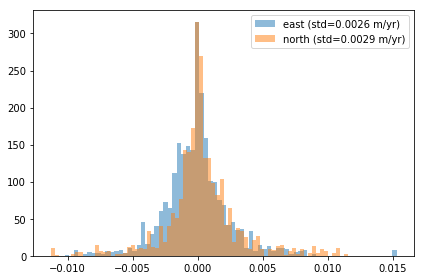

In [121]:
predicted = chain.predict(projection(data.longitude.values, data.latitude.values))
residuals = (data.velocity_east - predicted[0], data.velocity_north - predicted[1])
fig = plt.figure()
ax = plt.axes()
ax.hist(residuals[0], alpha=0.5, bins='auto', label='east (std={:.4f} m/yr)'.format(residuals[0].std()))
ax.hist(residuals[1], alpha=0.5, bins='auto', label='north (std={:.4f} m/yr)'.format(residuals[1].std()))
ax.legend()
plt.tight_layout()

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


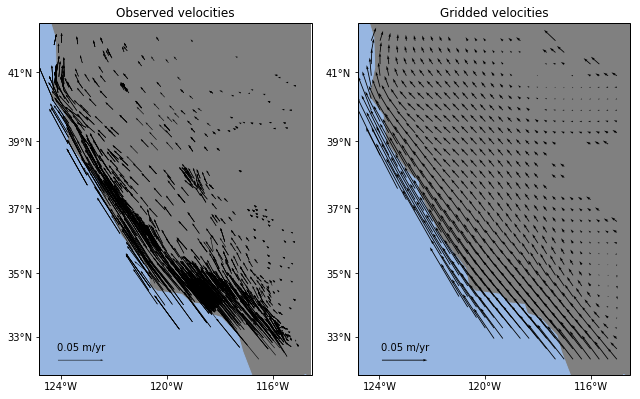

In [126]:
# Make a plot of the data using Cartopy to handle projections and coastlines
fig, axes = plt.subplots(1, 2, figsize=(9, 7),
                         subplot_kw=dict(projection=ccrs.Mercator()))
crs = ccrs.PlateCarree()
# Plot the two trend components
ax = axes[0]
tmp = ax.quiver(data.longitude.values, data.latitude.values,
          data.velocity_east.values, data.velocity_north.values,
          scale=0.3, transform=crs, color='k', width=0.002)
ax.quiverkey(tmp, 0.13, 0.18, 0.05, label='0.05 m/yr', coordinates='figure')
setup_map(ax, 'Observed velocities')

ax = axes[1]
tmp = ax.quiver(grid.longitude.values, grid.latitude.values,
          grid.east_component.values, grid.north_component.values,
          scale=0.3, transform=crs, width=0.003)
ax.quiverkey(tmp, 0.63, 0.18, 0.05, label='0.05 m/yr', coordinates='figure')
setup_map(ax, 'Gridded velocities')

plt.tight_layout()
plt.show()